In [1]:
from utils import *
from tqdm.auto import tqdm
from SALib.analyze import pawn, morris
from scipy.signal import correlate
from scipy.spatial import ConvexHull
from scipy.spatial import Delaunay
import numpy as np
import seaborn as sns
from ripser import ripser
import pandas as pd
import pickle
import time
import os
from scipy import signal as sp_signal
from scipy.stats import binned_statistic_2d
from scipy.stats import gaussian_kde
from collections import Counter

from sklearn.cluster import DBSCAN, KMeans
import warnings
warnings.filterwarnings("ignore")

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import matplotlib.patches as patches
from matplotlib.colors import Normalize
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({"font.size" : 15,
                     "figure.dpi" : 100, 
                     "grid.alpha" : 0.3, 
                     "axes.grid": False, 
                     "axes.axisbelow" : True,
                     "figure.figsize":(8,6),
                     "mathtext.fontset":"cm",
                     "xtick.labelsize": 14,
                     "ytick.labelsize": 14,
                     "axes.labelsize": 16, 
                     "legend.fontsize": 13.5})
plt.rc("text", usetex=False)
plt.rc("font", family="serif")

In [ ]:
result_dir = "cpt"

sen_results = []

for f in tqdm(os.listdir(result_dir)):
    with open(os.path.join(result_dir, f), "rb") as f:
        res = pickle.load(f)
    wealth = res["wealth"]
    health = res["health"]
    util = utility(res["wealth"][:,-1], res["health"][:,-1], alpha=res['params']['alpha'])
    sen_results.append(
        (res["params"], sen_welfare(util))
    )

with open(f"sen_welfare_{result_dir}.pickle", "wb") as f:
    pickle.dump(sen_results, f)

# CPT

In [7]:
directory = "cpt"

with open(f"sen_welfare_{directory}.pickle", "rb") as f:
    sen = pickle.load(f)

data = []
for idx,f in tqdm(enumerate(os.listdir(directory))):
    with open(os.path.join(directory, f), "rb") as f:
        P = pickle.load(f)["params"]
    elem = ((P["alpha"], P["gamma"], P["omega"], P["eta"], P["P_H_increase"], P["P_H_decrease"], P["w_delta_scale"], sen[idx][-1]))
    data.append(elem)

0it [00:00, ?it/s]

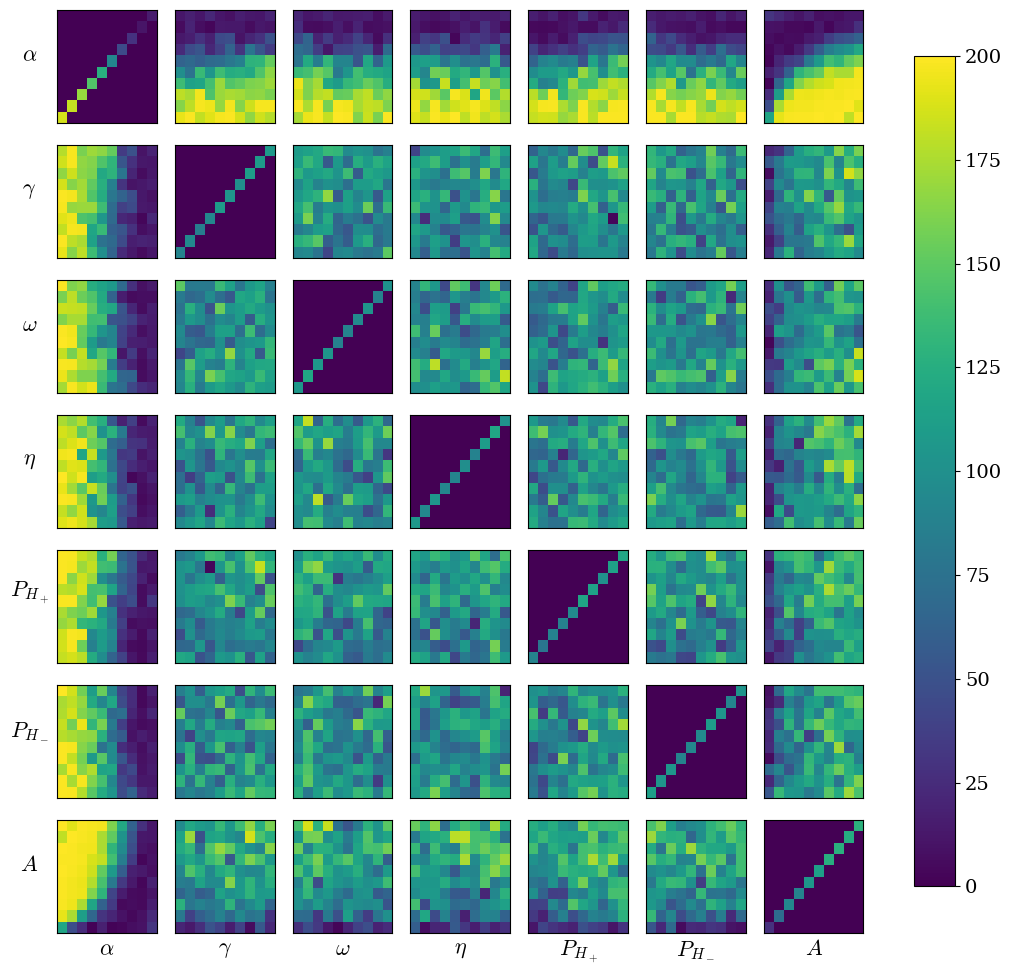

In [11]:
fig, axs = plt.subplots(7, 7, figsize=(11,10))

param_names = [r"$\alpha$", r"$\gamma$", r"$\omega$", r"$\eta$", r"$P_{H_+}$",  r"$P_{H_-}$", r"$A$"]
bounds = [[0,1], [0.4,0.8], [1,4], [0.5, 1], [0,1], [0,1], [0,1]]
S = np.array([d[-1] for d in data])

for i in range(7):
    pi_values = np.array([d[i] for d in data])
    pi_bounds = np.linspace(bounds[i][0], bounds[i][1], 11)
    for j in range(7):
        pj_values = np.array([d[j] for d in data])
        pj_bounds = np.linspace(bounds[j][0], bounds[j][1], 11)
        heatmap = np.zeros((10, 10))
        
        # Iterate over bins
        for a in range(10):
            for b in range(10):
                # Find indices that fall into this bin
                idxs = np.where(
                    (pi_values >= pi_bounds[a]) & (pi_values < pi_bounds[a+1]) &
                    (pj_values >= pj_bounds[b]) & (pj_values < pj_bounds[b+1])
                )[0]
                
                if len(idxs) > 0:
                    heatmap[a,b] = np.mean(S[idxs])
                else:
                    heatmap[a, b] = 0

        im = axs[i][j].imshow(heatmap, origin="lower", aspect="auto", cmap="viridis", vmin=0, vmax=200)
        axs[i][j].set_xticks([])
        axs[i][j].set_yticks([])
        if j == 0:
            axs[i][j].set_ylabel(param_names[i], rotation=0, labelpad=20)
        if i == 6:
            axs[i][j].set_xlabel(param_names[j])

        last_im = im

fig.tight_layout()
fig.colorbar(last_im, ax=axs.ravel().tolist(), shrink=0.9, norm="log")
plt.show()

# NO-CPT

In [13]:
directory = "nocpt"

with open(f"sen_welfare_{directory}.pickle", "rb") as f:
    sen = pickle.load(f)

data = []
for idx,f in tqdm(enumerate(os.listdir(directory))):
    with open(os.path.join(directory, f), "rb") as f:
        P = pickle.load(f)["params"]
    elem = ((P["alpha"], P["P_H_increase"], P["P_H_decrease"], P["w_delta_scale"], sen[idx][-1]))
    data.append(elem)

0it [00:00, ?it/s]

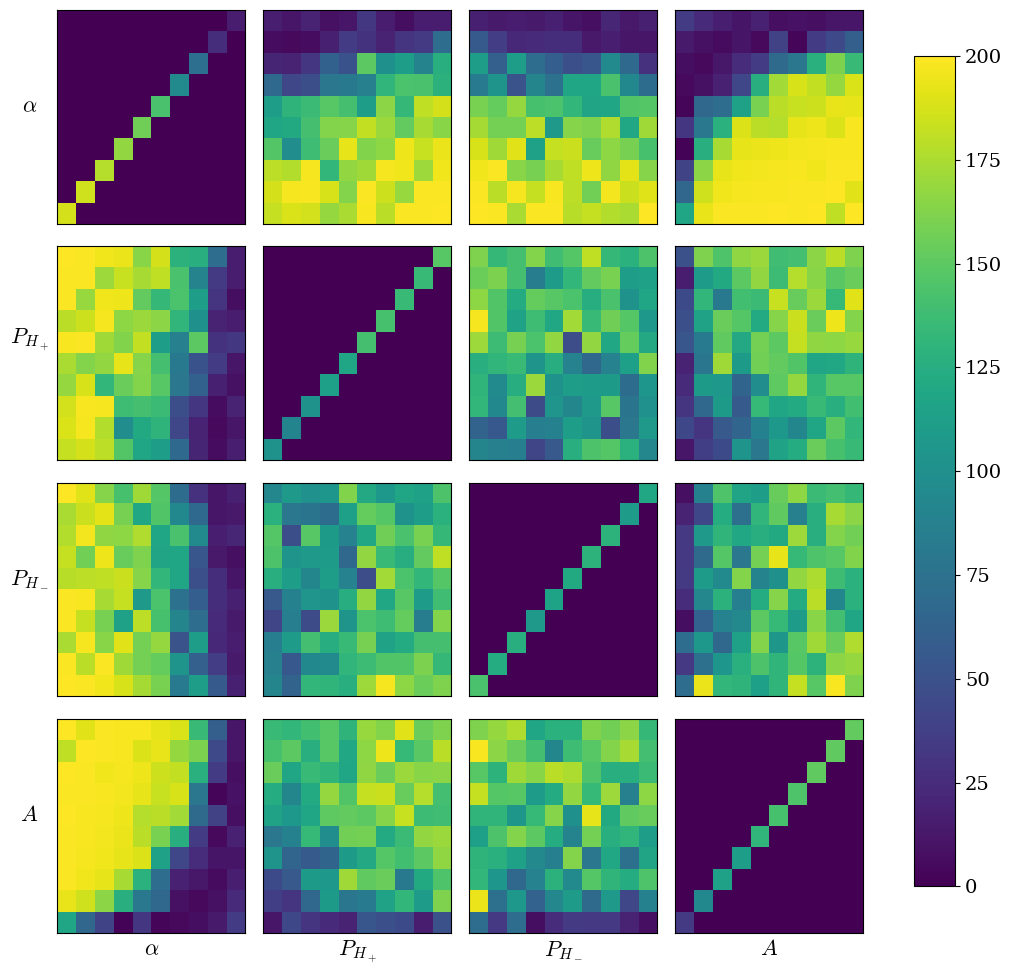

In [14]:
fig, axs = plt.subplots(4, 4, figsize=(11,10))

param_names = [r"$\alpha$", r"$P_{H_+}$", r"$P_{H_-}$", r"$A$"]
bounds = [[0,1], [0,1], [0,1], [0,1]]
S = np.array([d[-1] for d in data])

map_vals = []
for i in range(len(param_names)):
    pi_values = np.array([d[i] for d in data])
    pi_bounds = np.linspace(bounds[i][0], bounds[i][1], 11)
    for j in range(len(param_names)):
        pj_values = np.array([d[j] for d in data])
        pj_bounds = np.linspace(bounds[j][0], bounds[j][1], 11)
        heatmap = np.zeros((10, 10))

        # Iterate over bins
        for a in range(10):
            for b in range(10):
                # Find indices that fall into this bin
                idxs = np.where(
                    (pi_values >= pi_bounds[a]) & (pi_values < pi_bounds[a+1]) &
                    (pj_values >= pj_bounds[b]) & (pj_values < pj_bounds[b+1])
                )[0]

                if len(idxs) > 0:
                    heatmap[a,b] = np.mean(S[idxs])
                else:
                    heatmap[a, b] = 0

        im = axs[i][j].imshow(heatmap, origin="lower", aspect="auto", cmap="viridis", vmin=0, vmax=200)
        axs[i][j].set_xticks([])
        axs[i][j].set_yticks([])
        if j == 0:
            axs[i][j].set_ylabel(param_names[i], rotation=0, labelpad=20)
        if i == len(param_names)-1:
            axs[i][j].set_xlabel(param_names[j])
        last_im = im

        map_vals.append(heatmap.flatten())

fig.tight_layout()
fig.colorbar(last_im, ax=axs.ravel().tolist(), shrink=0.9, norm="log")
plt.show()

# KDE

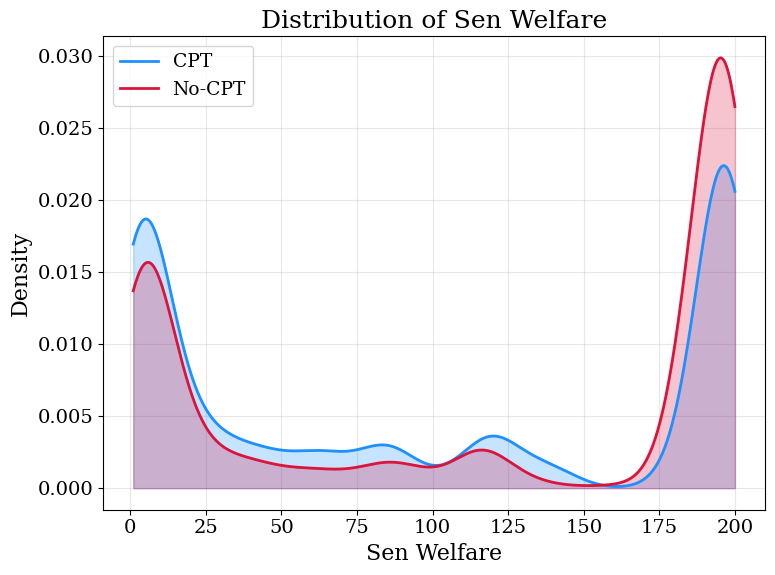

In [16]:
labels = ["CPT", "No-CPT"]
colors = ["dodgerblue", "crimson"]

for i, directory in enumerate(["cpt", "nocpt"]):
    with open(f"sen_welfare_{directory}.pickle", "rb") as f:
        sen = pickle.load(f)
    sen = [x[-1] for x in sen]

    # compute KDE
    kde = gaussian_kde(sen, bw_method=0.1)

    # grid for x-values
    x_vals = np.linspace(min(sen), max(sen), 500)
    y_vals = kde(x_vals)

    # normalize so area = 1 (proportion density)
    y_vals /= np.trapz(y_vals, x_vals)
    plt.plot(x_vals, y_vals, color=colors[i], label=labels[i], lw=2)
    plt.fill_between(x_vals, y_vals, color=colors[i], alpha=0.25)

plt.xlabel("Sen Welfare")
plt.ylabel("Density")
plt.title("Distribution of Sen Welfare")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()